In [2]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
from ebm.model import Network
import networkx as nx
from ebm.external_world import ExternalWorld, MNISTExternalWorld

from ebm.train_model import *


def pi(s):
    return torch.clamp(s, 0.0, 1.0)

class ExternalWorld:
    def __init__(self, x_values, y_values):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = len(self.x)



In [3]:
import torch.nn as nn
# XOR dataset
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
xor_y = np.array([0, 1, 1, 0], dtype=np.int64)

# ExternalWorld instance with XOR data
xor_world = ExternalWorld(xor_x, xor_y)


In [14]:
def get_particle_bgcolor(particle_value, cmap=plt.cm.PuBu, alpha=0.5):
    """Map a particle value in [-1, 1] to a softened background color."""
    normed = (particle_value + 1) / 2  # [-1, 1] → [0, 1]
    rgba = cmap(normed)
    r, g, b = rgba[:3]
    return (r, g, b, alpha)

def draw_node_labels_with_background(G, pos, ax, sample_particles):
    for n, (x, y) in pos.items():
        label = G.nodes[n]['label']
        i, j = n
        particle_val = sample_particles[i - 1][j].item() if i > 0 else 0.0
        facecolor = get_particle_bgcolor(particle_val)
        ax.text(
            x, y, label,
            fontsize=7,
            ha='center', va='center',
            bbox=dict(
                boxstyle='round,pad=0.3',
                facecolor=facecolor,
                edgecolor='black',
                linewidth=0.6
            )
        )

def compute_layout(layer_sizes, x_gap, y_gap):
    pos = {}
    for i, size in enumerate(layer_sizes):
        offset = (size - 1) * y_gap / 2
        for j in range(size):
            jitter = 0.3 if j % 2 == 0 else -0.3
            pos[(i, j)] = (i * x_gap, -j * y_gap + offset + jitter)
    return pos


In [29]:
def draw_energy_graph(net, sample_idx, y_gap=2.0, x_gap=3.0):




    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']
    layer_sizes = [net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]
    total_layers = len(layer_sizes)

    G = nx.DiGraph()
    sample_activations = [layer[sample_idx] for layer in net.layers]
    sample_particles = [p[sample_idx] for p in net.persistent_particles]
    edge_weights = []
    edge_contribs = []

    for i, layer_size in enumerate(layer_sizes):
        for j in range(layer_size):
            act = sample_activations[i][j].item()
            bias = net.biases[i][j].item()
            post_bias = act + bias if i > 0 else act
            particle = sample_particles[i - 1][j].item() if i > 0 else None
            input_val = act if i == 0 else None
            output_val = act if i == total_layers - 1 else None
            true_label = net.y_data[sample_idx].item() if i == total_layers - 1 else None

            label = f"{layer_labels[i]} {j}\n"
            if i > 0:
                label += f"Pre = {act:.2f}  Bias = {bias:.2f}\nPost = {post_bias:.2f}"
            else:
                label += f"Input = {input_val:.1f}"
            if output_val is not None:
                label += f"\nŷ = {output_val:.2f}  y = {true_label}"

            G.add_node((i, j), label=label, activation=act, layer=i)

    for idx, W in enumerate(net.weights):
        a_src = sample_activations[idx]
        a_tgt = sample_activations[idx + 1]
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j].item()
                contrib = -a_src[i].item() * w * a_tgt[j].item()
                G.add_edge((idx, i), (idx + 1, j), weight=w, contrib=contrib, label=f"{w:.2f}\nΔE={contrib:.2f}")
                edge_weights.append(w)
                edge_contribs.append(contrib)

    total_bias_energy = sum(-net.biases[i][j].item() * sample_activations[i][j].item()
                            for i in range(1, total_layers)
                            for j in range(layer_sizes[i]))
    total_energy = sum(edge_contribs) + total_bias_energy


    pos = compute_layout(layer_sizes, x_gap, y_gap)
    fig, ax = plt.subplots(figsize=(8, 3))
    edge_norm = plt.Normalize(vmin=-max(map(abs, edge_weights)), vmax=max(map(abs, edge_weights)))

    nx.draw_networkx_edges(
        G, pos, edge_color=edge_weights, edge_cmap=plt.cm.RdYlGn,
        edge_vmin=edge_norm.vmin, edge_vmax=edge_norm.vmax,
        arrows=True, arrowsize=10, ax=ax, connectionstyle='arc3,rad=0.08'
    )

    node_acts = [G.nodes[n]['activation'] for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_acts, cmap=plt.cm.coolwarm,
                           node_size=1400, edgecolors='black', ax=ax)

    draw_node_labels_with_background(G, pos, ax, sample_particles)

    edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax, label_pos=0.6)

    sm_edges = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=edge_norm)
    sm_edges.set_array(edge_weights)
    cbar = fig.colorbar(sm_edges, ax=ax)
    cbar.set_label("Weight", rotation=270, labelpad=15)

    ax.set_title(f"Sample {sample_idx} | Energy = {total_energy:.3f}", fontsize=13)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


In [33]:
def draw_energy_graph(net, sample_idx, y_gap=2.0, x_gap=3.0):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import networkx as nx
    import numpy as np

    def compute_layout(layer_sizes, x_gap, y_gap):
        pos = {}
        for i, size in enumerate(layer_sizes):
            offset = (size - 1) * y_gap / 2
            for j in range(size):
                jitter = 0.3 if j % 2 == 0 else -0.3
                pos[(i, j)] = (i * x_gap, -j * y_gap + offset + jitter)
        return pos

    def get_particle_bgcolor(particle_value, cmap=plt.cm.PuBu, alpha=0.5):
        normed = (particle_value + 1) / 2  # [-1, 1] -> [0, 1]
        rgba = cmap(normed)
        r, g, b = rgba[:3]
        return (r, g, b, alpha)

    def draw_node_labels_with_background(G, pos, ax, sample_particles):
        for n, (x, y) in pos.items():
            label = G.nodes[n]['label']
            i, j = n
            particle_val = sample_particles[i - 1][j].item() if i > 0 else 0.0
            facecolor = get_particle_bgcolor(particle_val)
            ax.text(
                x, y, label,
                fontsize=7,
                ha='center', va='center',
                bbox=dict(
                    boxstyle='round,pad=0.3',
                    facecolor=facecolor,
                    edgecolor='black',
                    linewidth=0.6
                )
            )

    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']
    layer_sizes = [net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]
    total_layers = len(layer_sizes)

    G = nx.DiGraph()
    sample_activations = [layer[sample_idx] for layer in net.layers]
    sample_particles = [p[sample_idx] for p in net.persistent_particles]
    edge_contribs = []

    for i, layer_size in enumerate(layer_sizes):
        for j in range(layer_size):
            act = sample_activations[i][j].item()
            bias = net.biases[i][j].item()
            post_bias = act + bias if i > 0 else act
            particle = sample_particles[i - 1][j].item() if i > 0 else None
            input_val = act if i == 0 else None
            output_val = act if i == total_layers - 1 else None
            true_label = net.y_data[sample_idx].item() if i == total_layers - 1 else None

            label = f"{layer_labels[i]} {j}\n"
            if i > 0:
                label += f"Pre = {act:.2f}  Bias = {bias:.2f}\nPost = {post_bias:.2f}"
            else:
                label += f"Input = {input_val:.1f}"
            if output_val is not None:
                label += f"\nŷ = {output_val:.2f}  y = {true_label}"

            G.add_node((i, j), label=label, activation=act, layer=i)

    for idx, W in enumerate(net.weights):
        a_src = sample_activations[idx]
        a_tgt = sample_activations[idx + 1]
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j].item()
                contrib = -a_src[i].item() * w * a_tgt[j].item()
                G.add_edge((idx, i), (idx + 1, j), weight=w, contrib=contrib, label=f"{w:.2f}\nΔE={contrib:.2f}")
                edge_contribs.append(contrib)

    total_bias_energy = sum(-net.biases[i][j].item() * sample_activations[i][j].item()
                            for i in range(1, total_layers)
                            for j in range(layer_sizes[i]))
    total_energy = sum(edge_contribs) + total_bias_energy

    pos = compute_layout(layer_sizes, x_gap, y_gap)
    fig, ax = plt.subplots(figsize=(8, 3))

    edge_norm = plt.Normalize(vmin=-max(map(abs, edge_contribs)), vmax=max(map(abs, edge_contribs)))
    edge_cmap = plt.cm.seismic  # red = high ΔE, blue = low ΔE

    edge_colors = [d['contrib'] for _, _, d in G.edges(data=True)]
    nx.draw_networkx_edges(
        G, pos, edge_color=edge_colors, edge_cmap=edge_cmap,
        edge_vmin=edge_norm.vmin, edge_vmax=edge_norm.vmax,
        arrows=True, arrowsize=10, ax=ax, connectionstyle='arc3,rad=0.08'
    )

    node_acts = [G.nodes[n]['activation'] for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_acts, cmap=plt.cm.coolwarm,
                           node_size=1400, edgecolors='black', ax=ax)

    draw_node_labels_with_background(G, pos, ax, sample_particles)

    # Color-coded edge labels by energy contribution
    for (u, v, d) in G.edges(data=True):
        (x0, y0), (x1, y1) = pos[u], pos[v]
        xm, ym = (x0 + x1) / 2, (y0 + y1) / 2
        contrib = d['contrib']
        color = edge_cmap(edge_norm(contrib))
        ax.text(xm, ym, d['label'], fontsize=6, ha='center', va='center',
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

    sm_edges = plt.cm.ScalarMappable(cmap=edge_cmap, norm=edge_norm)
    sm_edges.set_array(edge_contribs)
    cbar = fig.colorbar(sm_edges, ax=ax)
    cbar.set_label("ΔEnergy", rotation=270, labelpad=15)

    ax.set_title(f"Sample {sample_idx} | Energy = {total_energy:.3f}", fontsize=13)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


In [34]:
def visualize_all_samples(net):
    for sample_idx in range(len(net.x_data)):
        draw_energy_graph(net, sample_idx)


In [35]:
def train_net(net: Network, plot_graph = False):
    history = {"Energy": [], "Cost": [], "Error": []}
    epochs, batch_size = net.hyperparameters["n_epochs"], net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg, n_it_pos, alphas = net.hyperparameters["n_it_neg"], net.hyperparameters["n_it_pos"], net.hyperparameters["alphas"]


    snapshot_epochs = np.linspace(0, epochs - 1, 2, dtype=int)
    # with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
    for epoch in range(epochs):
        for i in range(n_batches):
            net.update_mini_batch_index(i)
            net.negative_phase(n_it_neg)
            net.positive_phase(n_it_pos, *alphas)

        # Measure and log
        E, C, error = net.measure()
        history["Energy"].append(E)
        history["Cost"].append(C)
        history["Error"].append(error * 100)

        if(plot_graph):
            if epoch in snapshot_epochs:
            # if(history["Error"][-1]< 0.001):
                plot_network_weights(net, epoch)
                visualize_all_samples(net)
    # Plot results
    res = np.mean(history["Error"][-4:])
    if(plot_graph):
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        for ax, (key, color) in zip(axes, [("Energy", "blue"), ("Cost", "orange"), ("Error", "red")]):
            ax.plot(history[key], label=key, color=color)
            ax.set_title(f"{key} over Epochs")
        plt.tight_layout()
        plt.show()
    return res

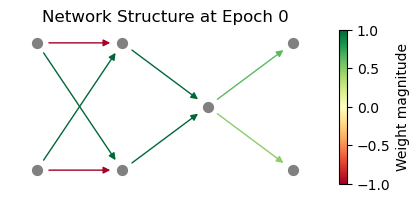

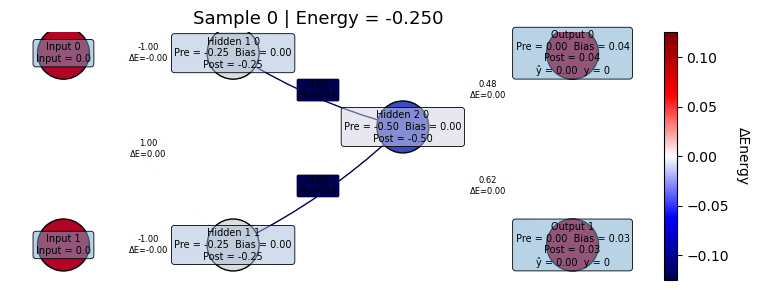

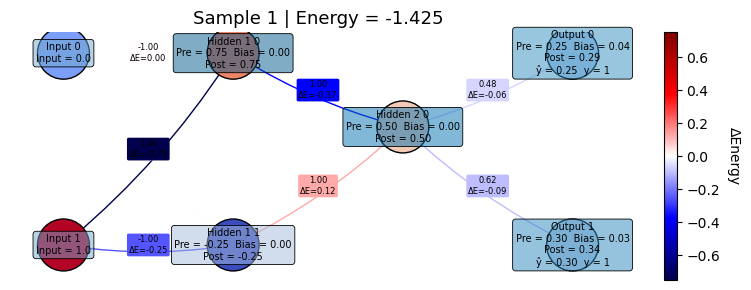

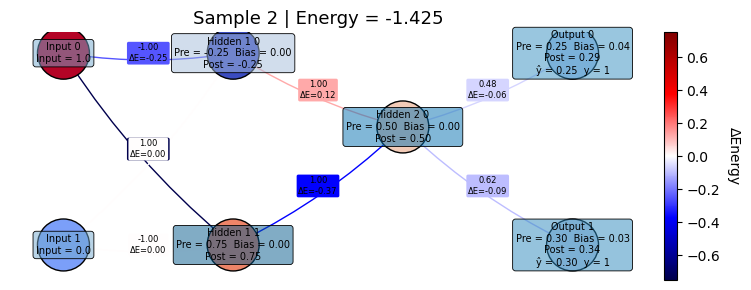

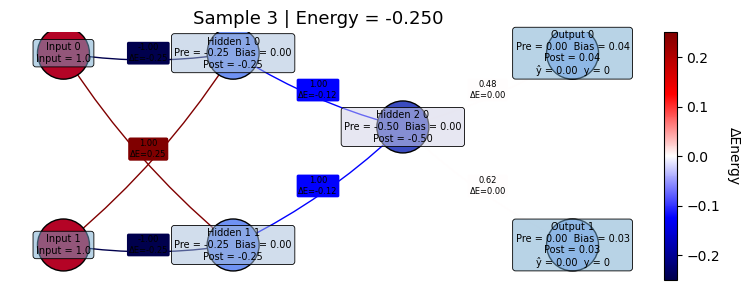

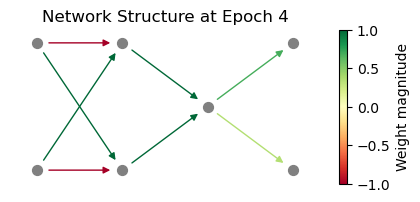

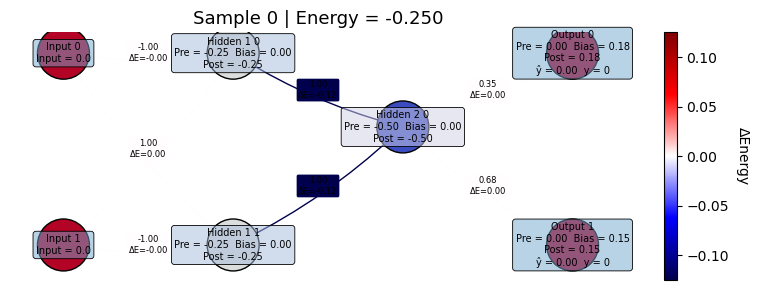

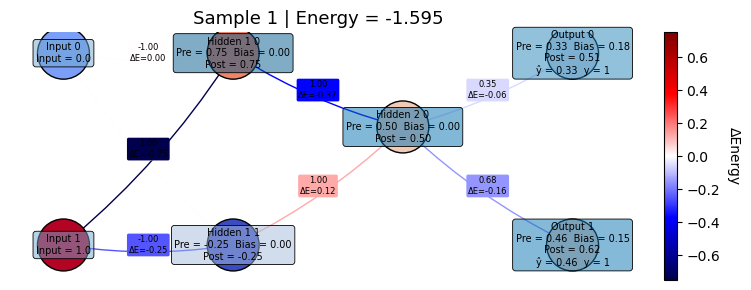

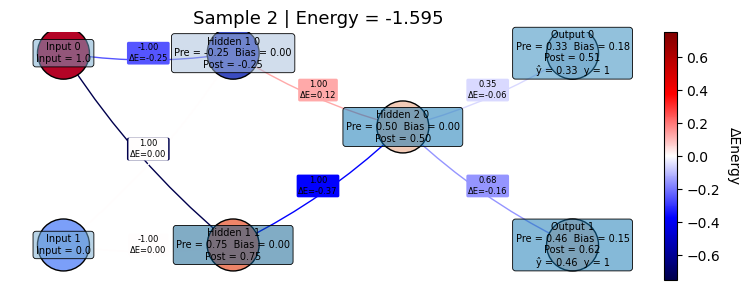

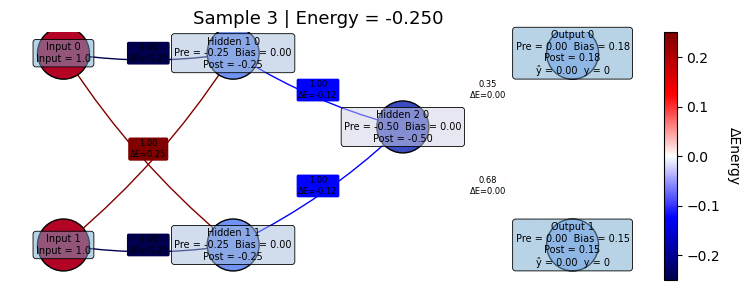

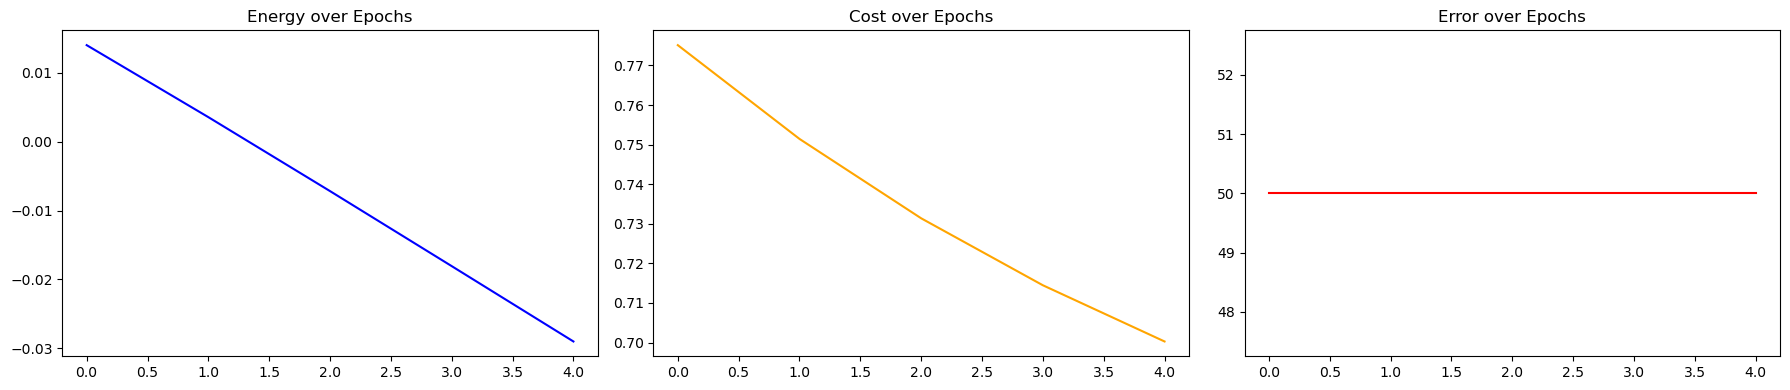

err 50.0
[tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]]), tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.0000, 0.0000],
        [0.3328, 0.4617],
        [0.3328, 0.4617],
        [0.0000, 0.0000]])]
[tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0.1763, 0.1538])]
[tensor([[-1.,  1.],
        [ 1., -1.]]), tensor([[1.0000],
        [1.0000]]), tensor([[0.3464, 0.6831]])]
[tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.0000, 0.0000],
        [0.3328, 0.4617],
        [0.3328, 0.4617],
        [0.0000, 0.0000]])]


In [36]:
xor_net = Network(
            name=f"xor_trial",
            external_world=xor_world,
            hyperparameters={
                "hidden_sizes": [2, 1],
                "output_size": 2,
                "batch_size": 4,
                "n_epochs": 5,  # just test untrained net
                "n_it_neg": 1,
                "n_it_pos": 1,
                "alphas": [0.1,0.1,0.1],
                             "activation": "relu"
            }
        )

        # Unpack init into weights and biases

init = [-1.   ,      1.   ,      1.    ,    -1.     ,    1.0000024 , 1.0000024]
init = torch.tensor(init, dtype=torch.float32)

with torch.no_grad():
    xor_net.weights[0][:] = init[0:4].reshape(2, 2) #torch.tensor([-1, -0.25, 0.25, 1]).reshape(2, 2)
    xor_net.weights[1][:] = init[4:6].reshape(2, 1)# torch.tensor([-1, 1]).reshape(2, 1)


# Evaluate the net — assume this function exists
print('err', train_net(xor_net, plot_graph= True))
# print("Total layer sum:", sum(l.sum() for l in xor_net.layers).item())
# print("Total weight sum:", sum(w.sum() for w in xor_net.weights).item())
# print("Total bias sum:", sum(b.sum() for b in xor_net.biases).item())

print(xor_net.layers)
print(xor_net.biases)
print(xor_net.weights)
print(xor_net.persistent_particles)




[tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]]), tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.5000, 0.0000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.5000, 0.0000]])]
[tensor([[-1.0375,  0.0125],
        [ 0.0125, -1.0375]]), tensor([[1.0000],
        [1.0000]]), tensor([[-1.,  1.]])]
[tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0., 0.])]
